In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Package & Dependencies Setup

In [17]:
"""Install NSL package"""
!pip install --upgrade neural_structured_learning

Requirement already up-to-date: neural_structured_learning in /usr/local/lib/python3.6/dist-packages (1.3.1)


In [18]:
import numpy as np
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
from neural_structured_learning.tools import graph_utils
import neural_structured_learning as nsl
import tensorflow_addons as tfa
from copy import deepcopy
from sklearn.metrics import multilabel_confusion_matrix
import random
import os
import PIL
import time
import re

tf.keras.backend.clear_session()
print("Version: ", tf.__version__)
print("keras", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.3.0
keras 2.4.0
Eager mode:  True
GPU is available


In [19]:
from graph_data_processing import GraphDataProcess
from AAE_model import AAE
from Kmeans import KMeans, KMeansModels
from nsl_data_processing import GenerateTrainTestDict, NSLDataFormat
from AD_model_builder import AD_params, ADModelBuilder, AccEarlyStop

In [24]:
''' label definition: NonDemented - 0, VeryMildDemented - 1, MildDemented -2, ModerateDemented -3 '''
label_list = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
root_path ='/content/drive/MyDrive/AD Project/codes/graph_images_balanced_II/'  

# 2. Balancing Dataset

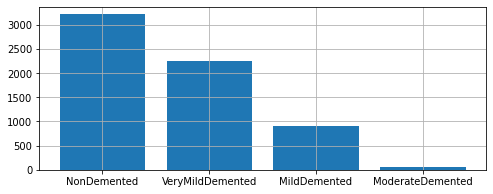

In [ ]:
'''image counts before balancing'''
image_counts={}
for label in label_list: 
    image_counts[f'{label}_image_counts'] = len(os.listdir(f'{root_path}{label}/'))
count_list = list(image_counts.values())
plt.figure(figsize=(8,3))
plt.bar(label_list, count_list)
plt.grid()
plt.show()

In [ ]:
'''balancing images(Note: images in the cloud drive is balanced already, so no need to run it)'''
# GraphDataProcess.balance_dataset(root_path=root_path, 
#                                  label_list=label_list, 
#                                  image_size=(208, 176), 
#                                  balance_vision=False)                           # NOTE: needs to comment out if loading data via MRI tfr files and this only works for orignal dataset 

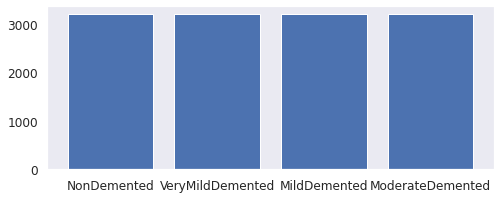

In [ ]:
'''image counts before balancing'''
image_counts={}
for label in label_list: 
    image_counts[f'{label}_image_counts'] = len(os.listdir(f'{root_path}{label}/'))
count_list = list(image_counts.values())
plt.figure(figsize=(8,3))
plt.bar(label_list, count_list)
plt.grid()
plt.show()

# 3. Seperate Train and Test MRI images

In [ ]:
'''setup the train and test data folder under the root path (Note: all .tfr files for both train and test folders are uploaded to the repo, so could be commented out)'''
# GraphDataProcess.setup_train_test_folders(root_path, label_list, ratio=0.7) 

train_data_size/label(rougly):  2240
test_data_size/label(rougly):  960
NonDemented folder is split...
VeryMildDemented folder is split...
MildDemented folder is split...
ModerateDemented folder is split...


# 4. Redefine root path and all data path(NOTE: Must run this cell for the following process) 

In [26]:
'''define all paths for data processing'''
root_path = '/content/drive/MyDrive/AD Project/codes/graph_images_balanced_II/train/'                     # root_path for train data folder
root_path_test = '/content/drive/MyDrive/AD Project/codes/graph_images_balanced_II/test/'                 # root_path for test data folder
path_list = [f'{root_path}{label}/' for label in label_list]                                               # path list for train MRI images under each label
path_list_test = [f'{root_path_test}{label}/' for label in label_list]                                     # path list for test MRI images under each label
tfr_list = [f'{root_path}{label}.tfr' for label in label_list]                                             # path list for train MRI tfr files under each label
tfr_list_test = [f'{root_path_test}{label}.tfr' for label in label_list]                                   # path list for test MRI tfr files under each label
tfr_rep_list = [f'{root_path}{label}_AAErep.tfr' for label in label_list]                                  # path list for train MRI represents tfr files under each label
train_tfr_path = f'{root_path}train_data.tfr'                                                              # path for the final train graph data

[2209, 2262, 2266, 2235]


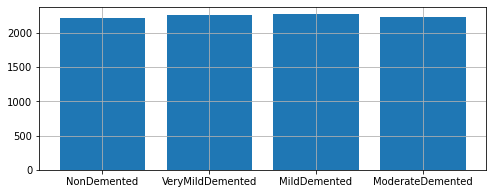

In [22]:
'''image counts for TRAIN dataset'''
image_counts={}
for label in label_list: 
    image_counts[f'{label}_image_counts'] = len(os.listdir(f'{root_path}{label}/'))
count_list = list(image_counts.values())
print(count_list)
plt.figure(figsize=(8,3))
plt.bar(label_list, count_list)
plt.grid()
plt.show()

[991, 938, 934, 965]


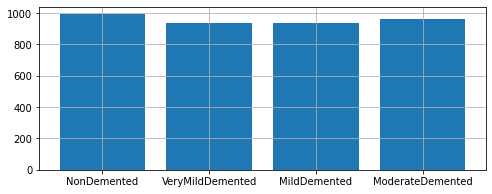

In [23]:
'''image counts for TEST dataset'''
image_counts={}
for label in label_list: 
    image_counts[f'{label}_image_counts'] = len(os.listdir(f'{root_path_test}{label}/'))
count_list = list(image_counts.values())
print(count_list)
plt.figure(figsize=(8,3))
plt.bar(label_list, count_list)
plt.grid()
plt.show()

# 5. Image & Graph Data Processing

In [ ]:
"""generate tfr files for TRAIN MRI data"""
# GraphDataProcess.generate_tfr_raw(path_list=path_list, tfr_list=tfr_list)    # NOTE: all train MRI tfr files have been uploaded into git repo, so this needs to comment out!

In [ ]:
"""generate tfr files for TEST MRI data"""
# GraphDataProcess.generate_tfr_raw(path_list=path_list_test, tfr_list=tfr_list_test)  #NOTE: all test MRI tfr files have been uploaded into git repo. this needs to comment out!  

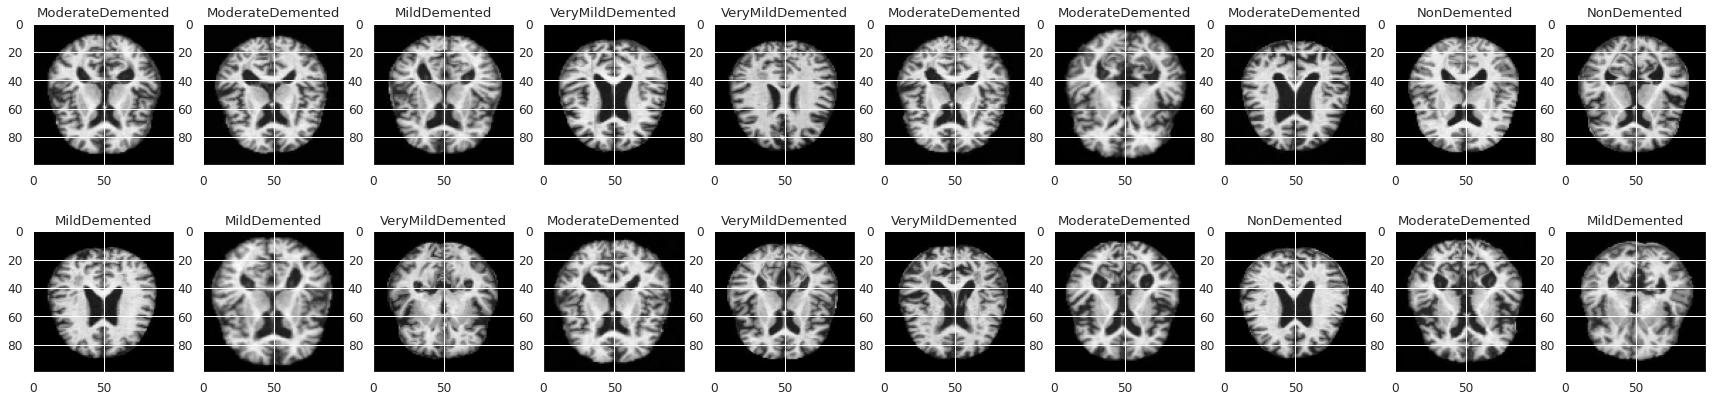

In [ ]:
'''Plot parsed TRAIN image tensors with size at 100 * 100 * 3'''
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list, 
                                                           batch_size=20, 
                                                           size=(100,100),
                                                           channels=3,
                                                           shuffle=True)
dt = iter(image_dataset).get_next()
plt.figure(figsize=(30,7))
for img_index, img_tensor in enumerate(dt['image_tensor']):
    ax = plt.subplot(2, 10, img_index + 1)
    plt.imshow(img_tensor)
    plt.title(label_list[dt['label'].numpy()[img_index]])

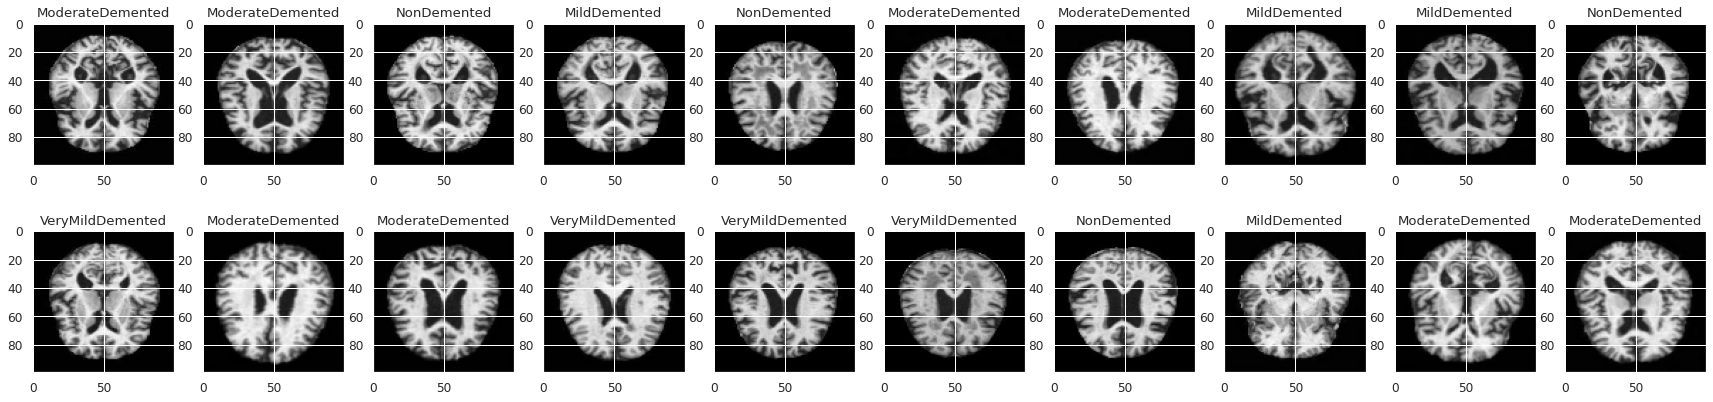

In [ ]:
'''Plot parsed TEST image tensors with size at 100 * 100 * 3'''
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list_test, 
                                                           batch_size=20, 
                                                           size=(100,100),
                                                           channels=3,
                                                           shuffle=True)
dt = iter(image_dataset).get_next()
plt.figure(figsize=(30,7))
for img_index, img_tensor in enumerate(dt['image_tensor']):
    ax = plt.subplot(2, 10, img_index + 1)
    plt.imshow(img_tensor)
    plt.title(label_list[dt['label'].numpy()[img_index]])

# 6. Generate AAE represents for Train MRI Images

In [ ]:
'''Generate AAE represents'''
latent_dim = 128
learning_rate = 0.0001
channels = 3
real_mean = 0
real_std = 1
batch = 1
size=(100, 100)
epochs= 400
checkpoint_path = '/content/drive/MyDrive/AD Project/codes/AAE_model_checkpoints_balance/aae_model_checkpoints_balance_colab'
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list, 
                                                           batch_size=batch, 
                                                           size= size, 
                                                           channels= channels, 
                                                           shuffle=True)
aae = AAE(latent_dim=latent_dim, 
          image_channels=channels,
          aae_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True))
# aae.load_weights(checkpoint_path)           # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run

In [ ]:
# aae.fit(image_dataset=image_dataset,
#         checkpoints_path=checkpoint_path,
#         batch_size=1,
#         real_mean=real_mean,
#         real_std=real_std,
#         epochs=epochs,)  

epoch:  1, epoch_time: 56.69452, total_loss: 2.57803, discriminator_loss: 1.51731, generator_loss: 0.67796, reconstruction_loss: 0.38276
epoch:  2, epoch_time: 59.51162, total_loss: 2.46143, discriminator_loss: 1.42652, generator_loss: 0.66054, reconstruction_loss: 0.37437
epoch:  3, epoch_time: 59.01142, total_loss: 2.44896, discriminator_loss: 1.39630, generator_loss: 0.68860, reconstruction_loss: 0.36406
epoch:  4, epoch_time: 56.34815, total_loss: 2.43748, discriminator_loss: 1.39619, generator_loss: 0.69027, reconstruction_loss: 0.35102
epoch:  5, epoch_time: 59.68504, total_loss: 2.43011, discriminator_loss: 1.39233, generator_loss: 0.69102, reconstruction_loss: 0.34676
epoch:  6, epoch_time: 59.33165, total_loss: 2.42811, discriminator_loss: 1.39188, generator_loss: 0.69164, reconstruction_loss: 0.34459
epoch:  7, epoch_time: 55.69169, total_loss: 2.42549, discriminator_loss: 1.39168, generator_loss: 0.69099, reconstruction_loss: 0.34282
epoch:  8, epoch_time: 56.80138, total_lo

epoch: 61, epoch_time: 56.83391, total_loss: 2.40934, discriminator_loss: 1.38757, generator_loss: 0.69289, reconstruction_loss: 0.32889
epoch: 62, epoch_time: 55.62391, total_loss: 2.40850, discriminator_loss: 1.38694, generator_loss: 0.69281, reconstruction_loss: 0.32875
epoch: 63, epoch_time: 55.92915, total_loss: 2.40875, discriminator_loss: 1.38740, generator_loss: 0.69275, reconstruction_loss: 0.32861
epoch: 64, epoch_time: 56.96150, total_loss: 2.40889, discriminator_loss: 1.38753, generator_loss: 0.69291, reconstruction_loss: 0.32845
epoch: 65, epoch_time: 57.81271, total_loss: 2.40983, discriminator_loss: 1.38830, generator_loss: 0.69279, reconstruction_loss: 0.32874
epoch: 66, epoch_time: 55.77898, total_loss: 2.40870, discriminator_loss: 1.38737, generator_loss: 0.69275, reconstruction_loss: 0.32858
epoch: 67, epoch_time: 57.73539, total_loss: 2.40871, discriminator_loss: 1.38743, generator_loss: 0.69281, reconstruction_loss: 0.32846
epoch: 68, epoch_time: 56.18680, total_lo

epoch:121, epoch_time: 56.68380, total_loss: 2.40641, discriminator_loss: 1.38671, generator_loss: 0.69307, reconstruction_loss: 0.32664
epoch:122, epoch_time: 55.30648, total_loss: 2.40651, discriminator_loss: 1.38665, generator_loss: 0.69332, reconstruction_loss: 0.32654
epoch:123, epoch_time: 58.90709, total_loss: 2.40556, discriminator_loss: 1.38655, generator_loss: 0.69250, reconstruction_loss: 0.32651
epoch:124, epoch_time: 57.15746, total_loss: 2.40669, discriminator_loss: 1.38666, generator_loss: 0.69338, reconstruction_loss: 0.32665
epoch:125, epoch_time: 60.31975, total_loss: 2.40674, discriminator_loss: 1.38694, generator_loss: 0.69313, reconstruction_loss: 0.32667
epoch:126, epoch_time: 55.92375, total_loss: 2.40613, discriminator_loss: 1.38643, generator_loss: 0.69306, reconstruction_loss: 0.32663
epoch:127, epoch_time: 56.06035, total_loss: 2.40688, discriminator_loss: 1.38692, generator_loss: 0.69308, reconstruction_loss: 0.32688
epoch:128, epoch_time: 56.67940, total_lo

epoch:181, epoch_time: 58.46066, total_loss: 2.40545, discriminator_loss: 1.38641, generator_loss: 0.69343, reconstruction_loss: 0.32561
epoch:182, epoch_time: 60.28455, total_loss: 2.40527, discriminator_loss: 1.38676, generator_loss: 0.69296, reconstruction_loss: 0.32555
epoch:183, epoch_time: 58.36041, total_loss: 2.40455, discriminator_loss: 1.38631, generator_loss: 0.69286, reconstruction_loss: 0.32538
epoch:184, epoch_time: 55.35359, total_loss: 2.40561, discriminator_loss: 1.38661, generator_loss: 0.69351, reconstruction_loss: 0.32549
epoch:185, epoch_time: 56.18059, total_loss: 2.40492, discriminator_loss: 1.38619, generator_loss: 0.69309, reconstruction_loss: 0.32564
epoch:186, epoch_time: 56.23536, total_loss: 2.40578, discriminator_loss: 1.38694, generator_loss: 0.69324, reconstruction_loss: 0.32561
epoch:187, epoch_time: 56.90530, total_loss: 2.40538, discriminator_loss: 1.38695, generator_loss: 0.69277, reconstruction_loss: 0.32566
epoch:188, epoch_time: 57.58966, total_lo

epoch:241, epoch_time: 55.98128, total_loss: 2.40495, discriminator_loss: 1.38667, generator_loss: 0.69349, reconstruction_loss: 0.32480
epoch:242, epoch_time: 57.48615, total_loss: 2.40476, discriminator_loss: 1.38667, generator_loss: 0.69322, reconstruction_loss: 0.32486
epoch:243, epoch_time: 56.20423, total_loss: 2.40432, discriminator_loss: 1.38617, generator_loss: 0.69323, reconstruction_loss: 0.32492
epoch:244, epoch_time: 56.19898, total_loss: 2.40441, discriminator_loss: 1.38630, generator_loss: 0.69332, reconstruction_loss: 0.32480
epoch:245, epoch_time: 56.78899, total_loss: 2.40449, discriminator_loss: 1.38695, generator_loss: 0.69276, reconstruction_loss: 0.32478
epoch:246, epoch_time: 55.64973, total_loss: 2.40436, discriminator_loss: 1.38679, generator_loss: 0.69267, reconstruction_loss: 0.32490
epoch:247, epoch_time: 56.96813, total_loss: 2.40380, discriminator_loss: 1.38603, generator_loss: 0.69309, reconstruction_loss: 0.32468
epoch:248, epoch_time: 58.49044, total_lo

epoch:301, epoch_time: 58.18575, total_loss: 2.40319, discriminator_loss: 1.38638, generator_loss: 0.69289, reconstruction_loss: 0.32392
epoch:302, epoch_time: 57.22131, total_loss: 2.40336, discriminator_loss: 1.38589, generator_loss: 0.69346, reconstruction_loss: 0.32400
epoch:303, epoch_time: 56.02164, total_loss: 2.40284, discriminator_loss: 1.38605, generator_loss: 0.69277, reconstruction_loss: 0.32402
epoch:304, epoch_time: 55.99345, total_loss: 2.40430, discriminator_loss: 1.38630, generator_loss: 0.69388, reconstruction_loss: 0.32412
epoch:305, epoch_time: 56.11008, total_loss: 2.40366, discriminator_loss: 1.38641, generator_loss: 0.69308, reconstruction_loss: 0.32417
epoch:306, epoch_time: 55.30200, total_loss: 2.40356, discriminator_loss: 1.38650, generator_loss: 0.69298, reconstruction_loss: 0.32407
epoch:307, epoch_time: 56.16788, total_loss: 2.40365, discriminator_loss: 1.38643, generator_loss: 0.69314, reconstruction_loss: 0.32407
epoch:308, epoch_time: 58.13957, total_lo

epoch:361, epoch_time: 57.91885, total_loss: 2.40376, discriminator_loss: 1.38652, generator_loss: 0.69357, reconstruction_loss: 0.32368
epoch:362, epoch_time: 58.22234, total_loss: 2.40335, discriminator_loss: 1.38597, generator_loss: 0.69373, reconstruction_loss: 0.32366
epoch:363, epoch_time: 57.12241, total_loss: 2.40270, discriminator_loss: 1.38658, generator_loss: 0.69250, reconstruction_loss: 0.32361
epoch:364, epoch_time: 57.93188, total_loss: 2.40331, discriminator_loss: 1.38655, generator_loss: 0.69315, reconstruction_loss: 0.32360
epoch:365, epoch_time: 56.13707, total_loss: 2.40369, discriminator_loss: 1.38617, generator_loss: 0.69389, reconstruction_loss: 0.32363
epoch:366, epoch_time: 57.18863, total_loss: 2.40230, discriminator_loss: 1.38640, generator_loss: 0.69231, reconstruction_loss: 0.32359
epoch:367, epoch_time: 56.35768, total_loss: 2.40312, discriminator_loss: 1.38601, generator_loss: 0.69355, reconstruction_loss: 0.32356
epoch:368, epoch_time: 59.51326, total_lo

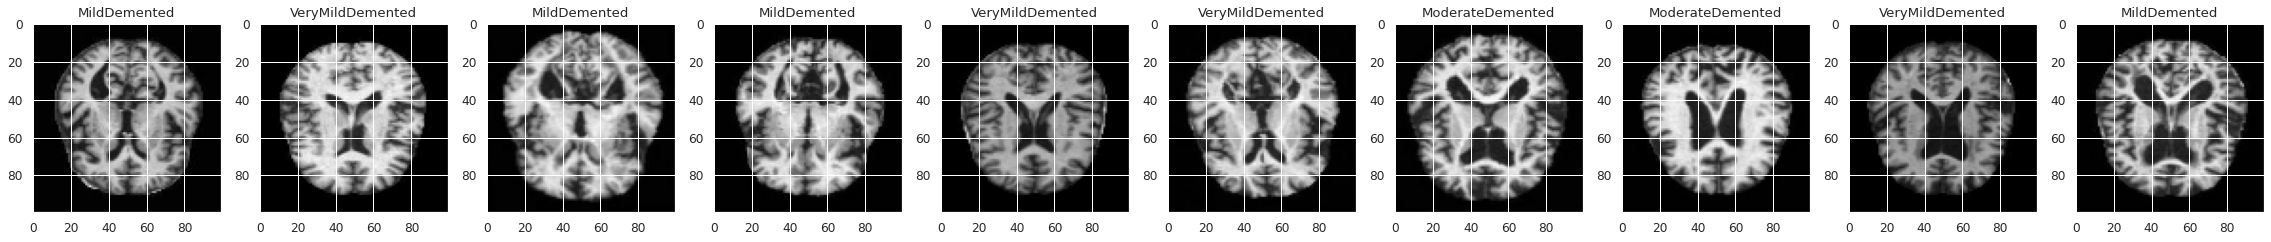

In [ ]:
'''Plot real images vs reconstructed images'''
tfr_list = [f'{root_path}{label}.tfr' for label in label_list]
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=tfr_list, 
                                                           batch_size=10, 
                                                           size=(100,100),
                                                           channels=3,
                                                           shuffle=True)
data = iter(image_dataset).get_next()
plt.figure(figsize=(40,50))
for img_index, img_tensor in enumerate(data['image_tensor']):
    plt.subplot(1, 10, img_index + 1)
    plt.imshow(img_tensor)
    plt.title(label_list[data['label'].numpy()[img_index]])

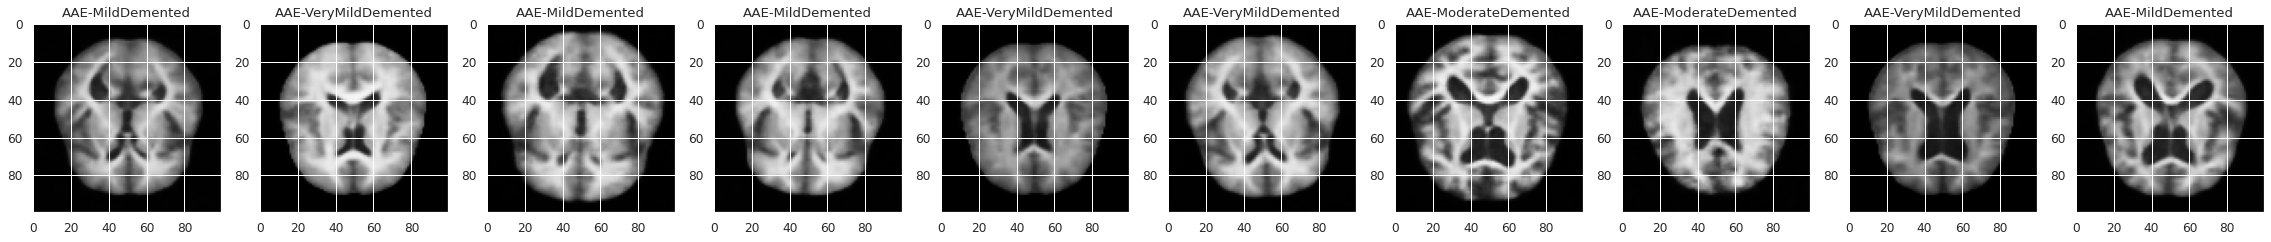

In [ ]:
plt.figure(figsize=(40,50))
for img_index, img_tensor in enumerate(data['image_tensor']):
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    _m, _l, rep = aae.encoder(img_tensor)
    img_new = aae.decoder(rep)
    img_new = tf.squeeze(img_new, axis=0)
    plt.subplot(1, 10, img_index + 1)
    plt.imshow(tf.abs(img_new))
    plt.title('AAE-'+label_list[data['label'].numpy()[img_index]])

In [ ]:
'''generate TRAIN image represents tfr files'''
img_data_list = [ GraphDataProcess.parse_tfr_to_image_tensor(path_list=[tfr_path], batch_size=1, size=(100,100), channels=3, shuffle=False) for tfr_path in tfr_list]
print(*img_data_list,sep='\n')
# GraphDataProcess.generate_tfr_aae_represent(image_dataset_list=img_data_list, aae_model=aae, tfr_rep_path=tfr_rep_list)         # NOTE: AAE rep tfr files are uploaded to git repo, so could be comment out 

<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>
<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>
<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>
<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>


In [ ]:
"""generate K_means models for each label data"""
batch= 5000
rep_dim= 128
K_value_list = [10,10, 10, 10] # for both train and test data
epoch= 50
Kmeans_model_list = KMeansModels.generate_model_list(path_list = tfr_rep_list, rep_dim=rep_dim, K_list=K_value_list, epoch=epoch, batch=batch)


====================== Model 0 training ======================

epoch:  1 ,centroid mean:  0.16548063
epoch:  2 ,centroid mean:  0.15953104
epoch:  3 ,centroid mean:  0.14553759
epoch:  4 ,centroid mean:  0.13878433
epoch:  5 ,centroid mean:  0.1346122
epoch:  6 ,centroid mean:  0.1316336
epoch:  7 ,centroid mean:  0.12977125
epoch:  8 ,centroid mean:  0.1276975
epoch:  9 ,centroid mean:  0.12663862
epoch:  10 ,centroid mean:  0.1255425
epoch:  11 ,centroid mean:  0.124458015
epoch:  12 ,centroid mean:  0.12311788
epoch:  13 ,centroid mean:  0.1215177
epoch:  14 ,centroid mean:  0.11994733
epoch:  15 ,centroid mean:  0.11818729
epoch:  16 ,centroid mean:  0.11683599
epoch:  17 ,centroid mean:  0.11581081
epoch:  18 ,centroid mean:  0.114782795
epoch:  19 ,centroid mean:  0.11402768
epoch:  20 ,centroid mean:  0.11348178
epoch:  21 ,centroid mean:  0.11257838
epoch:  22 ,centroid mean:  0.11156716
epoch:  23 ,centroid mean:  0.11080743
epoch:  24 ,centroid mean:  0.110291734
epoch:  25

In [ ]:
'''generate the complete graph with clustering for TRAIN data only'''
threshold = 0.90
complete_graph = GraphDataProcess.generate_complete_graph_with_cluster_kmeans(tfr_rep_path_list= tfr_rep_list,
                                                                              prefix_list= [0,1,2,3], 
                                                                              model_list= Kmeans_model_list, 
                                                                              represent_dim= 128, 
                                                                              file_output_path= f'{root_path}AD_graph_AAE_KMeans.tsv',
                                                                              similarity_threshold=threshold)
complete_graph

{'0c4': {'0c0': 0.923863, '0c7': 0.935854, '0c9': 0.936451},
 '0c9': {'0c0': 0.951082, '0c4': 0.936451, '0c6': 0.935606, '0c7': 0.93325},
 '0c7': {'0c0': 0.942529, '0c4': 0.935854, '0c9': 0.93325},
 '0c0': {'0c2': 0.949339,
  '0c4': 0.923863,
  '0c5': 0.916713,
  '0c6': 0.97497,
  '0c7': 0.942529,
  '0c9': 0.951082},
 '0c6': {'0c0': 0.97497, '0c2': 0.956817, '0c9': 0.935606},
 '0c2': {'0c0': 0.949339, '0c1': 0.949815, '0c6': 0.956817},
 '0c1': {'0c2': 0.949815},
 '0c5': {'0c0': 0.916713},
 '0_2189': {'0_1003': 0.974023,
  '0_105': 0.964727,
  '0_1056': 0.939017,
  '0_1088': 0.932822,
  '0_1095': 0.936089,
  '0_112': 0.92123,
  '0_1137': 0.910733,
  '0_118': 0.94218,
  '0_1230': 0.906561,
  '0_1239': 0.975811,
  '0_1259': 0.953533,
  '0_13': 0.924135,
  '0_1326': 0.9542,
  '0_1389': 0.95696,
  '0_1397': 0.952516,
  '0_1415': 0.94395,
  '0_1420': 0.960651,
  '0_1436': 0.943971,
  '0_1462': 0.922974,
  '0_1465': 0.91932,
  '0_15': 0.924914,
  '0_151': 0.948978,
  '0_1524': 0.966816,
  '0_

In [ ]:
"""count seed node number for each label"""
seed_count={}
for key in complete_graph.keys():
    split_content = key.split('_')[0]
    if 'c' not in split_content: 
        index=int(split_content)
        if index in [0,1,2,3] and (index in seed_count):
            seed_count[index] +=1
        elif index in [0,1,2,3] and (index not in seed_count):
            seed_count[index] =1
print(seed_count)

{0: 2190, 1: 2140, 2: 2194, 3: 2235}


In [ ]:
'''Generate the TRAIN dictionary with shuffled MRI images'''
train_examples, _ = GenerateTrainTestDict.get_train_test_dict(path_list=path_list, train_percentage=1)
print('train examples: ', len(train_examples.keys()))

train examples:  8972


In [ ]:
'''generate "train_data.tfr" by merging TRAIN examples with the complete AAE graph'''
# nsl_train= NSLDataFormat(seed_dict_examples= train_examples,
#                          rem_dict_examples= _, 
#                          graph= nsl.tools.read_tsv_graph(f'{root_path}AD_graph_AAE_KMeans.tsv'), 
#                          max_nbrs= 5)
# nsl_train.generate_node_nbrs_tfr(output_file_path=train_tfr_path)              #NOTE: train_data.tfr is uploaded to git repo, so this cell could be commented out

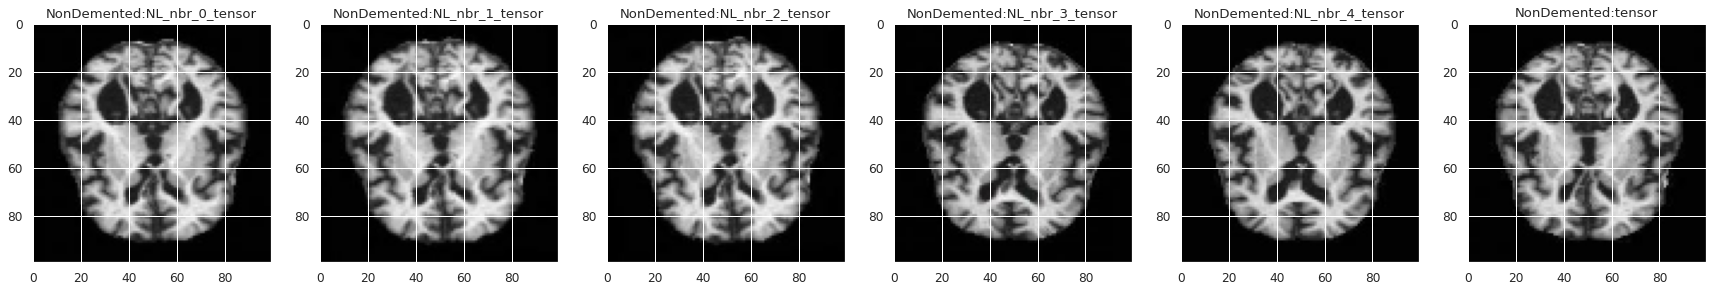

In [ ]:
'''parse train_graph_examples with clusters'''
parsed_image_size=(100,100)
parsed_image_channel=3
batch=1
max_seed_node_neighbours=5
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[train_tfr_path],
                                                   batch_size=batch,
                                                   max_neighbor_number= max_seed_node_neighbours,
                                                   image_size=parsed_image_size,
                                                   image_channels=parsed_image_channel,
                                                   shuffle=True)
data_sample = iter(train_image_dataset).get_next()

'''plot parsed train_graph examples with clusters'''
label =  tf.argmax(data_sample[1], axis=0)
sample = data_sample[0]
img_index=0
plt.figure(figsize=(30,10))
for key, value in sample.items():
    if key.split('_')[-1]=='tensor':
        plt.subplot(1,max_seed_node_neighbours+1,img_index + 1)
        img_tensor = tf.reshape(value, shape=value.shape[1:])
        plt.imshow(img_tensor)
        plt.title(f'{label_list[label.numpy()[0]]}:{key}')
        img_index +=1

## 7.VGG19 & VGG19-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = train_tfr_path

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

## 3.1 VGG19 Base Model Training
### val_acc: 0.92, val_auc: 0.99, val_f1_score: 0.92

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path = '/content/drive/MyDrive/AD Project/codes/VGG19_model_checkpoints/vgg19_weights_new'
params.early_stop_base_line=0.90
params.train_epoch=50
"""build a base_model and restore weights from last training"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',  tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
80142336/80134624 [==============================] - 1s 0us/step
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
batch_norm

In [ ]:
'''train base model'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, 
                                                          mode='max',save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpoints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     69/Unknown - 15s 216ms/step - loss: 0.9203 - accuracy: 0.6211 - auc: 0.8602 - f1_score: 0.6004

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.43809, saving model to /content/drive/MyDrive/AD Project/codes/VGG19_model_checkpoints/vgg19_weights_new
69/69 [==============================] - 22s 312ms/step - loss: 0.9203 - accuracy: 0.6211 - auc: 0.8602 - f1_score: 0.6004 - val_loss: 1.1158 - val_accuracy: 0.4381 - val_auc: 0.7887 - val_f1_score: 0.4038
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.7315 - auc: 0.9319 - f1_score: 0.7180
Epoch 00002: val_accuracy improved from 0.43809 to 0.51332, saving model to /content/drive/MyDrive/AD Project/codes/VGG19_model_checkpoints/vgg19_weights_new
69/69 [==============================] - 20s 292ms/step - loss: 0.6207 - accuracy: 0.7315 - auc: 0.9319 - f1_score: 0.7180 - val_loss: 1.0034 - val_accuracy: 0.5133 - val_auc: 0.8273 - val_f1_score: 0.4898
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.7736 - auc: 0.9505 - f1_score: 0.7635
Epoch 00003: val_acc

In [ ]:
'''evaluate the base model'''
base_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 4s 140ms/step - loss: 0.2315 - accuracy: 0.9120 - auc: 0.9889 - f1_score: 0.9124


[0.23151913285255432,
 0.911964476108551,
 0.9888662099838257,
 0.9124097228050232]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

In [ ]:
len(data)

3828

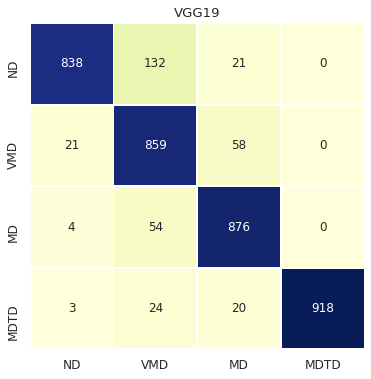

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "VGG19")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(base_model,data, data_label)

TN: [2809 2680 2795 2863]
TP: [838 859 876 918]
FN: [153  79  58  47]
FP: [ 28 210  99   0]
Acc: [0.95271682 0.92450366 0.95898642 0.98772205]
ER(Error rate): [0.04728318 0.07549634 0.04101358 0.01227795]
Recall(TP rate): [0.84561049 0.91577825 0.9379015  0.95129534]
Specialty(TN rate): [0.99013042 0.92733564 0.96579129 1.        ]
Fall Out(FP rate): [0.00986958 0.07266436 0.03420871 0.        ]
Miss Rate(FN rate): [0.15438951 0.08422175 0.0620985  0.04870466]


## 3.2 VGG19-NSL Model Training
### val_acc: 0.97, val_auc: 0.99, val_f1_score: 0.97

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path ='/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_97'
params.early_stop_base_line=0.97
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
"""build a base_model"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
"""build a NSL model on top of the base model and retore weights from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
80142336/80134624 [==============================] - 1s 0us/step
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
batch_norm

In [ ]:
''' setup early stoping and checkpoints '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''NSL model training'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                294976    
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     69/Unknown - 56s 808ms/step - loss: 0.8950 - accuracy: 0.6292 - auc: 0.8703 - f1_score: 0.6116 - scaled_graph_loss: 0.0154
Epoch 00001: val_accuracy improved from -inf to 0.67294, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_97
69/69 [==============================] - 62s 900ms/step - loss: 0.8950 - accuracy: 0.6292 - auc: 0.8703 - f1_score: 0.6116 - scaled_graph_loss: 0.0154 - val_loss: 0.7801 - val_accuracy: 0.6729 - val_auc: 0.8942 - val_f1_score: 0.6198
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.7343 - auc: 0.9332 - f1_score: 0.7235 - scaled_graph_loss: 0.0111
Epoch 00002: val_accuracy improved from 0.67294 to 0.71108, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_97
69/69 [==============================] - 61s 890ms/step - loss: 0.6253 - accuracy: 0.7343 - auc: 0.9332 - f1_score: 0.7235 - scaled_graph

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


30/30 [==============================] - 4s 136ms/step - loss: 0.0949 - accuracy: 0.9713 - auc: 0.9969 - f1_score: 0.9710


[0.09488795697689056,
 0.9712643623352051,
 0.9968827962875366,
 0.9709879755973816]

## 3.3 VGG19-NSL 5th block tunning
### val_acc: 0.98, val_auc: 0.99, val_f1_score: 0.98

In [ ]:
'''define params'''
params.learning_rate = 0.00005
params.checkpoint_restore_path = '/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_97'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_98'
params.early_stop_base_line=0.98
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base model'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').setup_VGG19_by_layer_names(trainable_layers=['block5_conv1', 
                                                                                                                                           'block5_conv2', 
                                                                                                                                           'block5_conv3', 
                                                                                                                                           'block5_conv4']).get_ADModel()
"""restore NSL model from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type, 
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.checkpoint_restore_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
trainable layer:  block5_conv1
trainable layer:  block5_conv2
trainable layer:  block5_conv3
trainable layer:  block5_conv4
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________

In [ ]:
"""set up training checkpoint and earlystop callbacks"""
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch')
callback_earlystop = AccEarlyStop(val_acc_base = params.early_stop_base_line)
"""NSL model training"""
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs= params.train_epoch,
                                        verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     69/Unknown - 52s 753ms/step - loss: 1.6121 - accuracy: 0.6404 - auc: 0.8563 - f1_score: 0.6394 - scaled_graph_loss: 0.0153
Epoch 00001: val_accuracy improved from -inf to 0.49556, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_98
69/69 [==============================] - 61s 881ms/step - loss: 1.6121 - accuracy: 0.6404 - auc: 0.8563 - f1_score: 0.6394 - scaled_graph_loss: 0.0153 - val_loss: 3.0820 - val_accuracy: 0.4956 - val_auc: 0.7293 - val_f1_score: 0.5949
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.7492 - auc: 0.9392 - f1_score: 0.7464 - scaled_graph_loss: 0.0110
Epoch 00002: val_accuracy improved from 0.49556 to 0.61311, saving model to /content/drive/My Drive/Projects/codes/VGG19_NSL_model_checkpoints/vgg19_nsl_weights_colab_new_98
69/69 [==============================] - 57s 831ms/step - loss: 0.6040 - accuracy: 0.7492 - auc: 0.9392 - f1_score: 0.7464 - scaled_graph

In [ ]:
"""evaluate tuned model"""
graph_reg_model.evaluate(test_image_dataset)

30/30 [==============================] - 4s 128ms/step - loss: 0.0699 - accuracy: 0.9822 - auc: 0.9973 - f1_score: 0.9822


[0.06989272683858871,
 0.9822361469268799,
 0.9973025321960449,
 0.9822361469268799]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


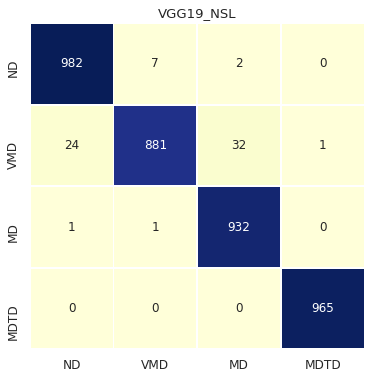

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, "VGG19_NSL")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(graph_reg_model, data, data_label)

TN: [2812 2882 2860 2862]
TP: [982 881 932 965]
FN: [ 9 57  2  0]
FP: [25  8 34  1]
Acc: [1897.  1881.5 1896.  1913.5]
ER(Error rate): [17.  32.5 18.   0.5]
Recall(TP rate): [0.99091826 0.93923241 0.99785867 1.        ]
Specialty(TN rate): [0.99118787 0.99723183 0.98825155 0.99965072]
Fall Out(FP rate): [0.00881213 0.00276817 0.01174845 0.00034928]
Miss Rate(FN rate): [0.00908174 0.06076759 0.00214133 0.        ]


# 7.DenseNet121 & DenseNet121-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

## 4.1 DenseNet Base Model Training
### val_acc: 0.9152, val_auc: 0.9906, val_f1_score: 0.91498

In [ ]:
'''define params'''
params.learning_rate=0.01
params.checkpoint_restore_path='/content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91'
params.early_stop_base_line=0.91
params.train_epoch=100

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_restore_path)

'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
29089792/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)  

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     69/Unknown - 14s 206ms/step - loss: 0.9499 - accuracy: 0.5922 - auc: 0.8462 - f1_score: 0.5560

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.64159, saving model to /content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91
69/69 [==============================] - 21s 301ms/step - loss: 0.9499 - accuracy: 0.5922 - auc: 0.8462 - f1_score: 0.5560 - val_loss: 0.7989 - val_accuracy: 0.6416 - val_auc: 0.8905 - val_f1_score: 0.6358
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.7284 - accuracy: 0.6709 - auc: 0.9026 - f1_score: 0.6436
Epoch 00002: val_accuracy improved from 0.64159 to 0.65648, saving model to /content/drive/My Drive/Projects/codes/DenseNet_model_checkpoints/densenet_model_weights_new_91
69/69 [==============================] - 18s 261ms/step - loss: 0.7284 - accuracy: 0.6709 - auc: 0.9026 - f1_score: 0.6436 - val_loss: 0.7371 - val_accuracy: 0.6565 - val_auc: 0.9020 - val_f1_score: 0.6389
Epoch 3/100
69/69 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.7104 - auc: 0.9244 - f1_scor

In [ ]:
'''evaluate base model'''
base_model.evaluate(test_image_dataset)

30/30 [==============================] - 2s 73ms/step - loss: 0.2432 - accuracy: 0.9127 - auc: 0.9902 - f1_score: 0.9142


[0.24320916831493378,
 0.9127481579780579,
 0.9901851415634155,
 0.9142027497291565]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

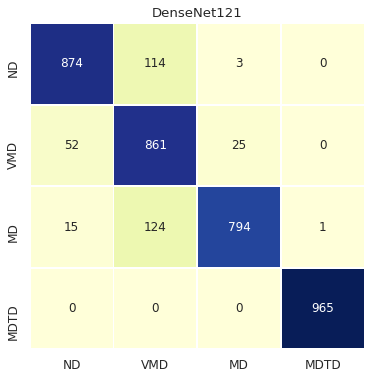

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "DenseNet121")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(base_model, data, data_label)

TN: [2770 2652 2866 2862]
TP: [874 861 794 965]
FN: [117  77 140   0]
FP: [ 67 238  28   1]
Acc: [0.95193312 0.9177116  0.95611285 0.99973877]
ER(Error rate): [0.04806688 0.0822884  0.04388715 0.00026123]
Recall(TP rate): [0.88193744 0.91791045 0.85010707 1.        ]
Specialty(TN rate): [0.9763835  0.91764706 0.99032481 0.99965072]
Fall Out(FP rate): [0.0236165  0.08235294 0.00967519 0.00034928]
Miss Rate(FN rate): [0.11806256 0.08208955 0.14989293 0.        ]


## 4.2 DenseNet_NSL Model Training
### val_acc: 0.9227, val_auc: 0.9914, val_f1_score: 0.92



In [ ]:
'''define params'''
params.learning_rate=0.001
params.restore_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92'
params.early_stop_base_line=0.92
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
_________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


     69/Unknown - 30s 430ms/step - loss: 0.9785 - accuracy: 0.6027 - auc: 0.8538 - f1_score: 0.5904 - scaled_graph_loss: 0.0198
Epoch 00001: val_accuracy improved from -inf to 0.69462, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92
69/69 [==============================] - 46s 664ms/step - loss: 0.9785 - accuracy: 0.6027 - auc: 0.8538 - f1_score: 0.5904 - scaled_graph_loss: 0.0198 - val_loss: 0.6903 - val_accuracy: 0.6946 - val_auc: 0.9165 - val_f1_score: 0.6186
Epoch 2/100
69/69 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.6914 - auc: 0.9103 - f1_score: 0.6771 - scaled_graph_loss: 0.0154
Epoch 00002: val_accuracy improved from 0.69462 to 0.72518, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92
69/69 [==============================] - 34s 487ms/step - loss: 0.7261 - accuracy: 0.6914 - auc: 0.9103 - f1_score: 0.6771 - 

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

1/1 [==============================] - 0s 17ms/step - loss: 0.2339 - accuracy: 0.9222 - auc: 0.9919 - f1_score: 0.9214


[0.23390400409698486,
 0.922152578830719,
 0.9918628334999084,
 0.9213719964027405]

## 4.3 DenseNet_NSL top 20 layers and bottom 50 laysers tuning
### val_acc: 0.963, val_auc: 0.991, val_f1_score: 0.963

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 64 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
params.learning_rate=0.0001
params.restore_path= '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_new_92'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95'
params.early_stop_base_line=0.95
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=10, middle_layers=None, bottom_layers=50).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
'''restore the model from last training'''
graph_reg_model.load_weights(params.restore_path)
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 106, 106, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


    137/Unknown - 94s 688ms/step - loss: 0.9150 - accuracy: 0.6490 - auc: 0.8835 - f1_score: 0.6304 - scaled_graph_loss: 0.0116
Epoch 00001: val_accuracy improved from -inf to 0.67450, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95
137/137 [==============================] - 103s 749ms/step - loss: 0.9150 - accuracy: 0.6490 - auc: 0.8835 - f1_score: 0.6304 - scaled_graph_loss: 0.0116 - val_loss: 0.6845 - val_accuracy: 0.6745 - val_auc: 0.9137 - val_f1_score: 0.6421
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.7501 - auc: 0.9447 - f1_score: 0.7405 - scaled_graph_loss: 0.0074
Epoch 00002: val_accuracy improved from 0.67450 to 0.75235, saving model to /content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95
137/137 [==============================] - 99s 719ms/step - loss: 0.5472 - accuracy: 0.7501 - auc: 0.9447 

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 3s 44ms/step - loss: 0.1276 - accuracy: 0.9634 - auc: 0.9939 - f1_score: 0.9635


[0.1275724619626999,
 0.9634273648262024,
 0.9939191937446594,
 0.9634959697723389]

## 4.4 DenseNet_NSL top 20 layers, middle 30 layers and bottom 20 laysers tuning
### val_acc: 0.9864, val_auc: 0.9978, val_f1_score: 0.9864

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 64 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.000005
params.restore_path='/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_new_95'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/DenseNet_NSL_model_checkpoints/densenet_nsl_weights_colab_tuning_98'
params.early_stop_base_line=0.98
params.train_epoch=100
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=20, middle_layers=[185, 215], bottom_layers=20).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
'''restore the model from last training'''
graph_reg_model.load_weights(params.restore_path)

In [ ]:
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 106, 106, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________

' NSL model training '

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 3s 43ms/step - loss: 0.0425 - accuracy: 0.9864 - auc: 0.9987 - f1_score: 0.9865


[0.04247911646962166,
 0.9864158630371094,
 0.9987107515335083,
 0.9865447878837585]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

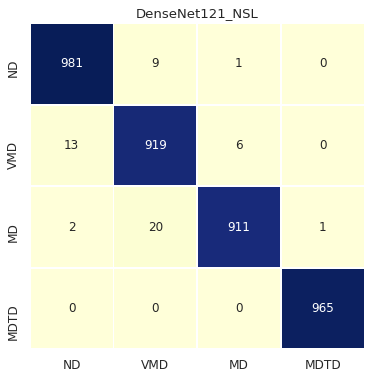

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, title="DenseNet121_NSL")

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=graph_reg_model, data=data, data_label=data_label)

TN: [2822 2861 2887 2862]
TP: [981 919 911 965]
FN: [10 19 23  0]
FP: [15 29  7  1]
Acc: [0.99346917 0.98746082 0.99216301 0.99973877]
ER(Error rate): [0.00653083 0.01253918 0.00783699 0.00026123]
Recall(TP rate): [0.98990918 0.97974414 0.97537473 1.        ]
Specialty(TN rate): [0.99471272 0.9899654  0.9975812  0.99965072]
Fall Out(FP rate): [0.00528728 0.0100346  0.0024188  0.00034928]
Miss Rate(FN rate): [0.01009082 0.02025586 0.02462527 0.        ]


#8.Xception & Xception-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.graph_path= f'{root_path}AD_graph_aae_kmeans.tsv'
params.test_tfr_path =  f'{root_path}test_data.tfr'
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

##5.1 Xception Base Model Training
### val_acc: 0.901, val_auc: 0.987, val_f1_score: 0.897

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_restore_path='/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90'
params.checkpoint_path='/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90'
params.early_stop_base_line=0.90
params.train_epoch=50

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_restore_path)
'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "Xception_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2359424   
__________________________________________________

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "Xception_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
__________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     69/Unknown - 19s 277ms/step - loss: 0.9846 - accuracy: 0.5874 - auc: 0.8402 - f1_score: 0.5660

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



Epoch 00001: val_accuracy improved from -inf to 0.64368, saving model to /content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90
69/69 [==============================] - 29s 417ms/step - loss: 0.9846 - accuracy: 0.5874 - auc: 0.8402 - f1_score: 0.5660 - val_loss: 0.8324 - val_accuracy: 0.6437 - val_auc: 0.8853 - val_f1_score: 0.6391
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.6768 - auc: 0.9057 - f1_score: 0.6621
Epoch 00002: val_accuracy improved from 0.64368 to 0.69279, saving model to /content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90
69/69 [==============================] - 24s 342ms/step - loss: 0.7263 - accuracy: 0.6768 - auc: 0.9057 - f1_score: 0.6621 - val_loss: 0.6742 - val_accuracy: 0.6928 - val_auc: 0.9195 - val_f1_score: 0.6863
Epoch 3/50
69/69 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.7086 - auc: 0.9240 - f1_score: 0.6999
Epoch 00

In [ ]:
"""evaluate base_model"""
base_model.evaluate(test_image_dataset)

30/30 [==============================] - 2s 61ms/step - loss: 0.2796 - accuracy: 0.9013 - auc: 0.9874 - f1_score: 0.8980


[0.27955442667007446,
 0.9012539386749268,
 0.9873639345169067,
 0.8979917764663696]

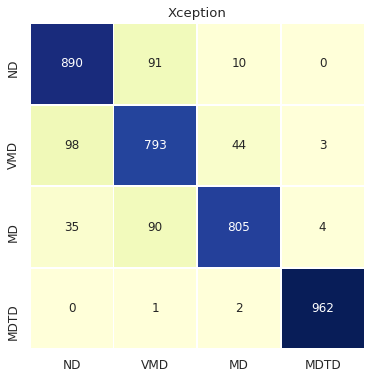

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]
ADModelBuilder.plot_confusion_mat(model=base_model, data=data, data_label=data_label, title="Xception", figsize=(6,6))

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=base_model, data=data, data_label=data_label)

TN: [2704 2708 2838 2856]
TP: [890 793 805 962]
FN: [101 145 129   3]
FP: [133 182  56   7]
Acc: [0.93887147 0.9145768  0.95167189 0.99738767]
ER(Error rate): [0.06112853 0.0854232  0.04832811 0.00261233]
Recall(TP rate): [0.89808274 0.84541578 0.86188437 0.99689119]
Specialty(TN rate): [0.95311949 0.93702422 0.98064962 0.99755501]
Fall Out(FP rate): [0.04688051 0.06297578 0.01935038 0.00244499]
Miss Rate(FN rate): [0.10191726 0.15458422 0.13811563 0.00310881]


##5.2 Xception_NSL Model Training
### val_acc: 0.954,val_auc: 0.990,val_f1_score:0.954

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'
'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.00005
params.restore_path = '/content/drive/My Drive/Projects/codes/Xception_model_checkpoints/xception_model_new_90'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95'
params.early_stop_base_line=0.95
params.train_epoch=50
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      2/Unknown - 1s 301ms/step - loss: 3.0072 - accuracy: 0.2500 - auc: 0.5468 - f1_score: 0.2443 - scaled_graph_loss: 0.0239WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2346s vs `on_train_batch_end` time: 0.3666s). Check your callbacks.
    137/Unknown - 82s 597ms/step - loss: 0.8293 - accuracy: 0.6618 - auc: 0.8905 - f1_score: 0.6381 - scaled_graph_loss: 0.0105
Epoch 00001: val_accuracy improved from -inf to 0.74974, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95
137/137 [==============================] - 88s 645ms/step - loss: 0.8293 - accuracy: 0.6618 - auc: 0.8905 - f1_score: 0.6381 - scaled_graph_loss: 0.0105 - val_loss: 0.5496 - val_accuracy: 0.7497 - val_auc: 0.9468 - val_f1_score: 0.6678
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.8036 - auc: 0.9631 - f1_score: 0.7962 - scaled_graph_loss: 0.0080
Epoch 00002: val_

##5.3 Xception_NSL Model top 10 and bottom 5 layers tunning
### val_acc: 0.972, val_auc: 0.996, val_f1_score: 0.971

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = f'{root_path}train_data.tfr'

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)
'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
'''define params'''
params.learning_rate=0.00001
params.restore_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_95'
params.checkpoint_path = '/content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_new_98'
params.early_stop_base_line=0.98
params.train_epoch=50
params.nsl_multiplier = 0.1
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()
'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

In [ ]:
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      2/Unknown - 1s 297ms/step - loss: 0.0806 - accuracy: 0.9766 - auc: 0.9992 - f1_score: 0.9725 - scaled_graph_loss: 0.0031WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2242s vs `on_train_batch_end` time: 0.3688s). Check your callbacks.
    137/Unknown - 80s 587ms/step - loss: 0.0793 - accuracy: 0.9744 - auc: 0.9987 - f1_score: 0.9745 - scaled_graph_loss: 0.0028
Epoch 00001: val_accuracy improved from -inf to 0.95690, saving model to /content/drive/My Drive/Projects/codes/Xception_NSL_model_checkpoints/xception_model_new_98
137/137 [==============================] - 87s 635ms/step - loss: 0.0793 - accuracy: 0.9744 - auc: 0.9987 - f1_score: 0.9745 - scaled_graph_loss: 0.0028 - val_loss: 0.1284 - val_accuracy: 0.9569 - val_auc: 0.9962 - val_f1_score: 0.9694
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9817 - auc: 0.9991 - f1_score: 0.9816 - scaled_graph_loss: 0.0022
Epoch 00002: 

In [ ]:
'''evaluate the model'''
graph_reg_model.evaluate(test_image_dataset)

60/60 [==============================] - 2s 34ms/step - loss: 0.0692 - accuracy: 0.9825 - auc: 0.9970 - f1_score: 0.9824


[0.06918579339981079,
 0.9824973940849304,
 0.9970408082008362,
 0.9823644757270813]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=tfr_list_test, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

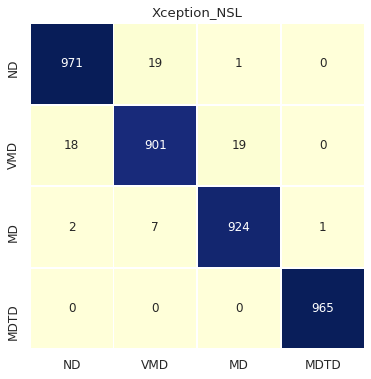

In [ ]:
ADModelBuilder.plot_confusion_mat(model=graph_reg_model, data=data, data_label=data_label, title="Xception_NSL", figsize=(6,6))

In [ ]:
ADModelBuilder.calc_confu_mat_for_each_label(model=graph_reg_model, data=data, data_label=data_label)

TN: [2817 2864 2874 2862]
TP: [971 901 924 965]
FN: [20 37 10  0]
FP: [20 26 20  1]
Acc: [0.98955068 0.98354232 0.99216301 0.99973877]
ER(Error rate): [0.01044932 0.01645768 0.00783699 0.00026123]
Recall(TP rate): [0.97981837 0.96055437 0.98929336 1.        ]
Specialty(TN rate): [0.9929503  0.99100346 0.99308915 0.99965072]
Fall Out(FP rate): [0.0070497  0.00899654 0.00691085 0.00034928]
Miss Rate(FN rate): [0.02018163 0.03944563 0.01070664 0.        ]
